# Homework 10
Ross Freeman

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

In [2]:
v_max = 28
tb = 1
k = 0.2
T = 100

## Exercise 1

In [3]:
def brake_rule(t):
    return k * t * np.exp((tb - t) / tb)

### Forward Euler Method

In [4]:
def for_euler(t, h, res):
    ind = int(round(t / h))
    if(ind < res.size):
        return res[ind]
    else:
        return for_euler(t - h, h, res) - h*v_max*brake_rule(t-h)

In [5]:
def euler_wrap(h):
    euler_res = np.asarray([0])

    t = h
    step = 1
    while t < T:
        euler_res = np.append(euler_res, for_euler(t, h, euler_res))
        step += 1
        t = step * h

    return euler_res

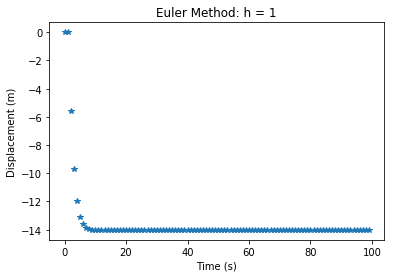

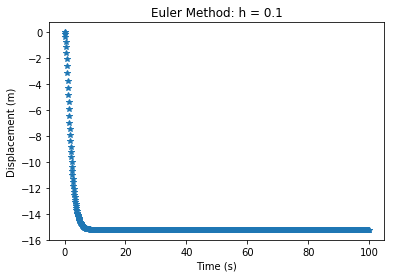

In [6]:
h = 1

plt.figure()
plt.title("Euler Method: h = 1")
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.plot(np.arange(0, 100, h), euler_wrap(h), '*')
plt.show()

h = 0.1

plt.figure()
plt.title("Euler Method: h = 0.1")
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.plot(np.arange(0, 100, h), euler_wrap(h), '*')
plt.show()

### Numerical Approximation

In [7]:
def num_approx(t):
    n = 1
    max_step = t / h # This is to normalize t relative to h to prevent floating point rounding errs
    result = 0
    
    while n < max_step:
        result += h/2 * (brake_rule(h * (n-1)) + brake_rule(h * n))
        n += 1
    return - v_max * result

In [8]:
def num_approx_wrap(h):
    num_res = np.asarray([0])
    t = h
    step = 1
    while t < T:
        num_res = np.append(num_res, num_approx(t))
        step += 1
        t = step * h
    return num_res


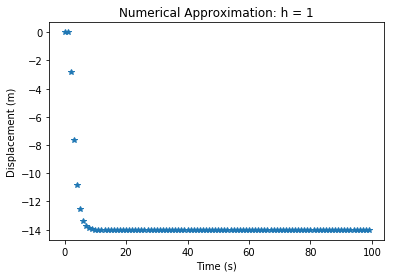

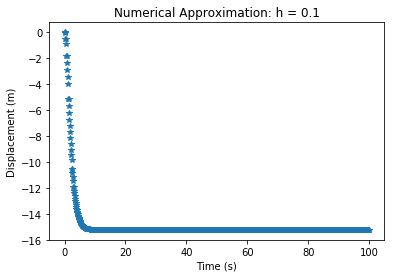

In [9]:
h = 1

plt.figure()
plt.title("Numerical Approximation: h = 1")
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.plot(np.arange(0, 100, h), num_approx_wrap(h), '*')
plt.show()

h = 0.1
plt.figure()
plt.title("Numerical Approximation: h = 0.1")
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.plot(np.arange(0, 100, h), num_approx_wrap(h), '*')
plt.show()

### Explicit Integration

In [10]:
exp_res = np.asarray([0])

t = h
step = 1
while t < T:
    int_val = -v_max * quad(brake_rule, 0, t)[0]
    exp_res = np.append(exp_res, int_val)
    step += 1
    t = step * h

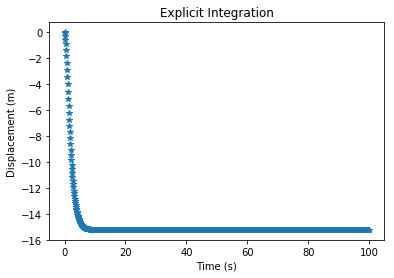

In [11]:
plt.figure()
plt.title("Explicit Integration")
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.plot(np.arange(0, 100, h), exp_res, '*')
plt.show()

### Observations

If the exact result from explicit integration were not available, the most ideal step size would be one that is as small as possible, allowing for more finite and accurate estimations. Being that this would require a tremendous amount of computing power, a higher value of h seems to give a relatively accurate result. As shown from both the Euler Forward and Numerical Approximation methods above, a value of $h = 0.1$ yielded results that are extremely similar to explicit integration. By contrast, a value of $h = 1$ resulted in not so accurate results, with the displacement levelling off at around -13m compared to -15m from explicit integration.

## Exercise 2

In [12]:
p_max = 0.04
d = 19
h = 0.01
num_cars = 40
tau = 130 # Multiplier for h

car_matrix = euler_wrap(h).reshape(1, int(100/h)) # First car

curr_car = np.asarray([0])

def dde(car, t):
    if(t < 0):
        return 0
    elif(car < car_matrix.shape[0]): # See if previous car
        return car_matrix[car][t]
    elif(t < curr_car.size): # See if previous value
        return curr_car[t]
    else: # Otherwise, calculate new value
        log = np.log(1 + p_max / np.e * (dde(car - 1, t - 1 - tau) - dde(car, t - 1 - tau)))
        prev = dde(car, t - 1)
        return prev + h * v_max * log
    
def check_crash(t, car): # Used for testing purposes to find tau for crash
    return car_matrix[car - 1][t] <= curr_car[t] - d

In [13]:
# NOTE: This step is needed to avoid floating point rounding errors
# This also normalizes t to be relative to h (so the actual time is t*h)
n_iter = int(T / h)

car = 1
while car < num_cars:
    t = 1
    while t < n_iter:
        curr_car = np.append(curr_car, dde(car, t))
        if(check_crash(t, car)):
            print('💥') # Check if crash occurred
        t += 1

    car_matrix = np.vstack((car_matrix, curr_car))
    car += 1
    curr_car = np.asarray([0])

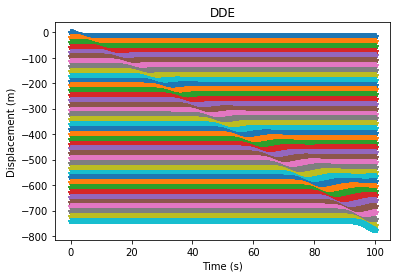

In [14]:
plt.figure()
plt.title("DDE")
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
for (val, car) in enumerate(car_matrix):
    car -= val * d # Adjust for distance between cars
    plt.plot(np.arange(0, 100, h), car, '*')
plt.show()

### Observations

To approximate the maximum reaction time before a crash, I created the `check_crash` function and simulated the system with various values until a crash was not detected. However, there are various points where $|displacement|$ increases, which theoretically shouldn't happen. I believe this is due to floating point rounding errors since it doesn't appear that a crash occurs despite this.